# 1.1 OBJECTIVE

Pick two pretrained CNN architectures, compare their specs, and apply one of them to a
small image classification task using transfer learning.

# 1.2 STEP 1: EXPLORE AND COMPARE MODELS


| **Feature**                   | **Model 1: MobileNetV2** | **Model 2: ResNet50**          |
|--------------------------------|--------------------------|---------------------------------|
| **Input Image Size**          | 224×224×3               | 224×224×3                      |
| **Parameters**                | ~3.5 million            | ~25.6 million                  |
| **Layers / Depth**            | ~53 layers              | 50 layers                      |
| **ImageNet Accuracy (Top-1)** | ~71.8%                  | ~76.0%                         |
| **Model Size (MB)**           | ~14 MB                  | ~98 MB                         |
| **Inference Speed (CPU)**     | ~75 ms per image        | ~100–120 ms per image          |


# 1.3 STEP 2: PICK A TOY DATASET


In [ ]:
pip install tensorflow tensorflow-datasets

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

We will use - CIFAR-10 dataset

# 1.4 STEP 3: TRANSFER LEARNING WORKFLOW




##   1. Load & preprocess the dataset



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
(ds_train_full, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

print(ds_info)




tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Kr

In [ ]:
# Constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Split train into train + validation
# e.g., 80% train, 20% validation
train_size = 0.8
train_count = int(ds_info.splits['train'].num_examples * train_size)

ds_train = ds_train_full.take(train_count)
ds_val = ds_train_full.skip(train_count)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Prepare train dataset
train_dataset = (
    ds_train
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare validation dataset
validation_dataset = (
    ds_val
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare test dataset
test_dataset = (
    ds_test
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# Inspect one batch
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [3 2 1 3 6 3 5 9 0 4 5 3 7 6 0 0 3 1 0 4 6 8 3 7 0 2 4 6 9 7 6 1]


In [ ]:
class_names = ds_info.features['label'].names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


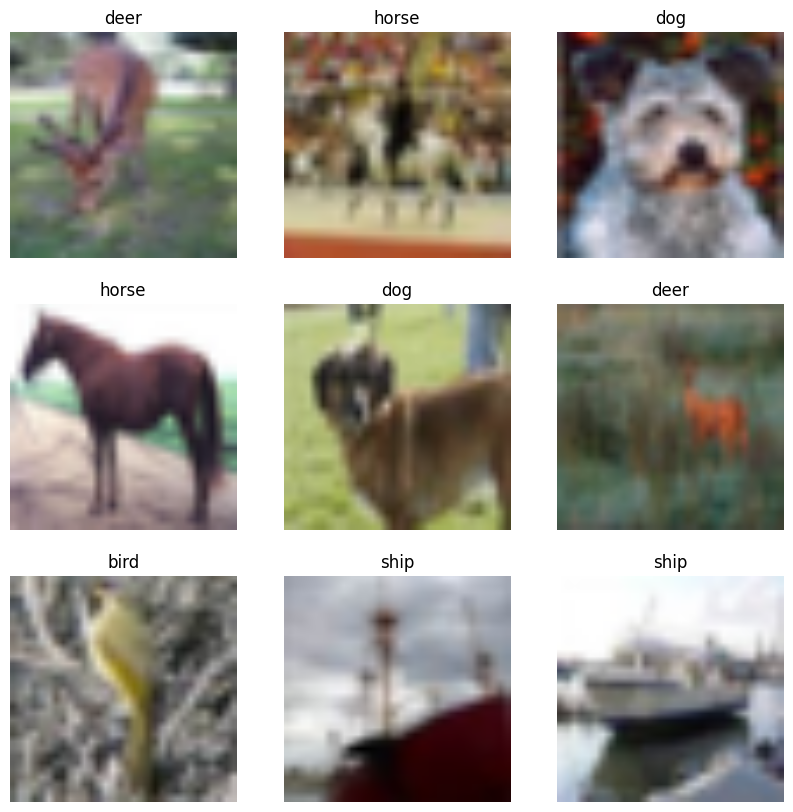

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 1250
Number of validation batches: 63
Number of test batches: 250


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



##   2. Load the pretrained model



In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)




##   3. Add custom classifier head



In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)

2

## 4.Train the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

Check model accuracy and los when model is untrained

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.0727 - loss: 2.6353


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_tuned_model.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True,
                                              verbose=1)

In [ ]:
initial_epochs = 30


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1584 - loss: 2.2551
Epoch 1: val_loss improved from 2.23359 to 2.23133, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step - accuracy: 0.1584 - loss: 2.2551 - val_accuracy: 0.1880 - val_loss: 2.2313 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1600 - loss: 2.2527
Epoch 2: val_loss improved from 2.23133 to 2.22967, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 67ms/step - accuracy: 0.1600 - loss: 2.2527 - val_accuracy: 0.2195 - val_loss: 2.2297 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1587 - loss: 2.2519
Epoch 3: val_loss improved from 2.22967 to 2.22588, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.1587 - loss: 2.2519 - val_accuracy: 0.2505 - val_loss: 2.2259 - learning_rate: 1.0000e-04
Epoch 4/30
1

In [ ]:
loss1, accuracy1 = model.evaluate(test_dataset)
print('Test loss :', loss1)
print('Test accuracy :', accuracy1)

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.1781 - loss: 2.2330
Test loss : 2.233692169189453
Test accuracy : 0.17987500131130219


In [ ]:
history_df = pd.DataFrame(history.history)

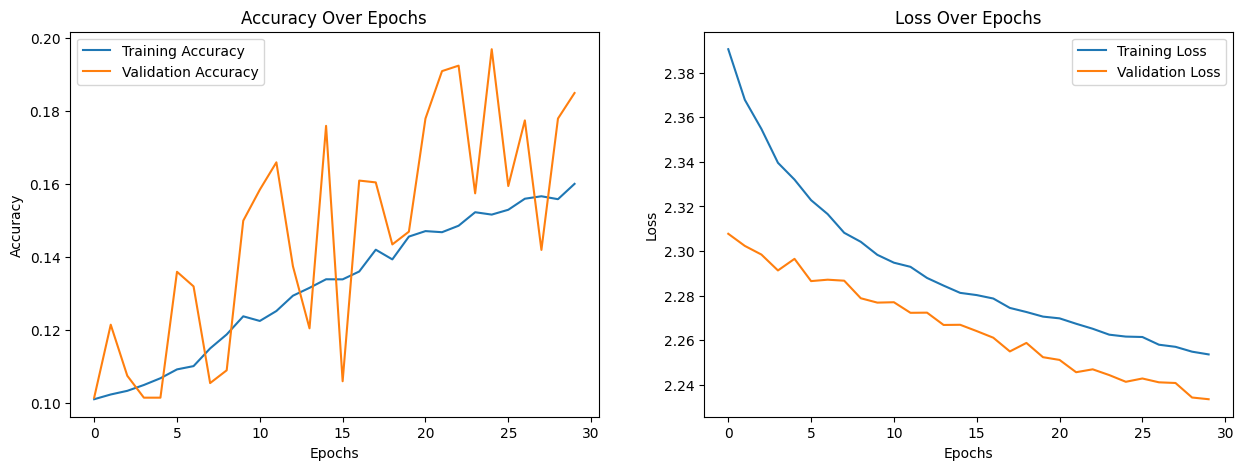

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

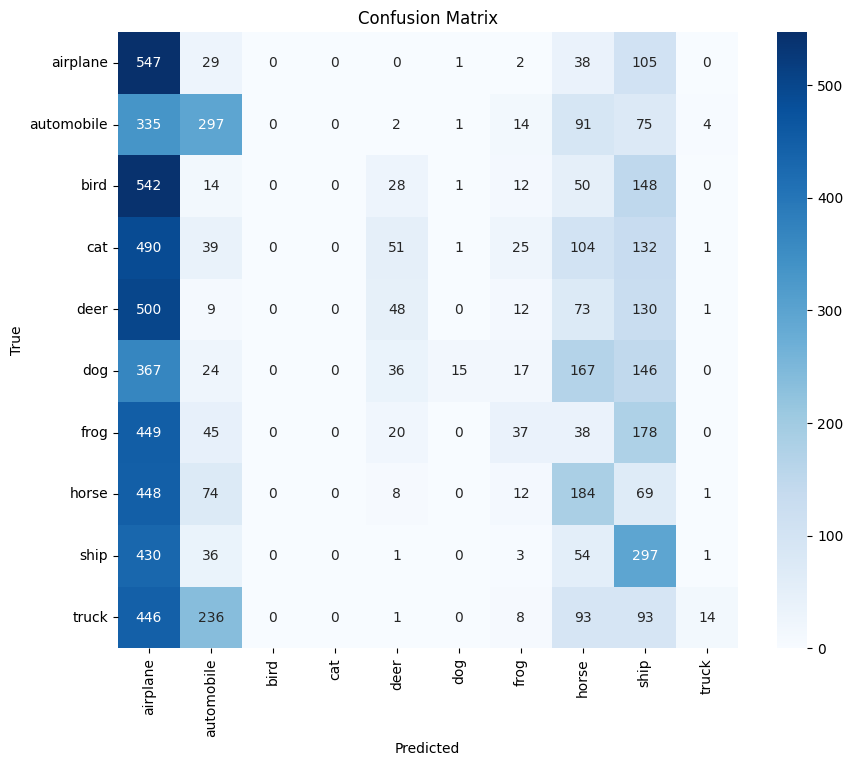

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 5. Fine-tune top few layers of the base model after initial training

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr, checkpoint, early_stop])

In [ ]:
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test loss :', loss2)
print('Test accuracy :', accuracy2)

In [ ]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [ ]:
history_full_df = pd.concat([history_df, history_fine_df])

In [ ]:
finetune_start_epoch = len(history_df)

In [ ]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print comparison side by side
print("\nComparison:")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1:<15.4f}{loss2:.4f}")
print(f"{'Accuracy':<15}{accuracy1:<15.4f}{accuracy2:.4f}")

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")